In [1]:
pip install yfinance

     |████████████████████████████████| 5.5MB 7.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=bf1b1c3a3fc881ed25e69c2a538157ba3f0d88b40f6b349435630c673e3d9545
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import pandas as pd
import numpy as np
import requests
import json
import ast
import yaml
import urllib
import yfinance
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
#from google.colab import drive

In [3]:
df_tweets = pd.read_csv('https://raw.githubusercontent.com/ml-group8/assignment/main/df_tweets_sentiment_3_analyzers.csv')
df_tweets

,Unnamed: 0,created_at,tweet,flare_sentiment,flare_confidence,txtblob_sentiment,txtblob_subjectivity,vader_sentiment,vader_compound_score
0,0,2021-03-20T15:59:46.000Z,I agree. I was looking to buy an electric car...,NEGATIVE,0.999987,NEGATIVE,0.495000,NEGATIVE,-0.6478
1,1,2021-03-20T15:59:30.000Z,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,0.999818,POSITIVE,1.000000,POSITIVE,0.7826
2,2,2021-03-20T15:59:09.000Z,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,0.999840,POSITIVE,1.000000,POSITIVE,0.7826
3,3,2021-03-20T15:59:03.000Z,Germany electric car and 60% US states margin...,NEGATIVE,0.975843,POSITIVE,0.200000,POSITIVE,0.4576
4,4,2021-03-20T15:58:49.000Z,Germany electric car and 60% US states margin...,NEGATIVE,0.975843,POSITIVE,0.200000,POSITIVE,0.4576
...,...,...,...,...,...,...,...,...,...
15143,15143,2021-03-13T17:01:27.000Z,"#Goodyearsbar #Timbo, Our #ClubCar limited sli...",POSITIVE,0.999870,NEGATIVE,0.142857,POSITIVE,0.0516
15144,15144,2021-03-13T17:01:15.000Z,Toyota X-Prologue Electric Car Teased Ahead of...,POSITIVE,0.970047,POSITIVE,0.166667,NEGATIVE,-0.2960
15145,15145,2021-03-13T17:00:56.000Z,I’m driving fossil fuel out of my economy. I...,NEGATIVE,0.834038,NEGATIVE,0.000000,NEGATIVE,0.0000
15146,15146,2021-03-13T17:00:37.000Z,Imagine buying an electric car to charge it at...,NEGATIVE,0.997597,NEGATIVE,0.000000,NEGATIVE,0.0000


In [7]:
# Keep only required columns
df_tweets = df_tweets[['created_at', 'tweet', 'flare_sentiment', 'txtblob_sentiment','vader_sentiment']]

# Convert created_at column from string to datetime
#def string_to_datetime(str_date):
#  str_date = str_date[:19]
#  return datetime.strptime(str_date, "%Y-%m-%dT%H:%M:%S")

df_tweets['created_at'] = df_tweets['created_at']#.map(lambda strDateTime: string_to_datetime(strDateTime))

max_date_tweets = df_tweets['created_at'].max().replace(minute=0, second=0, microsecond=0)
min_date_tweets = df_tweets['created_at'].min().replace(minute=0, second=0, microsecond=0)

df_tweets
#print(min_date_tweets)
#print(max_date_tweets)

,created_at,tweet,flare_sentiment,txtblob_sentiment,vader_sentiment
0,2021-03-20 15:59:46,I agree. I was looking to buy an electric car...,NEGATIVE,NEGATIVE,NEGATIVE
1,2021-03-20 15:59:30,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,POSITIVE,POSITIVE
2,2021-03-20 15:59:09,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,POSITIVE,POSITIVE
3,2021-03-20 15:59:03,Germany electric car and 60% US states margin...,NEGATIVE,POSITIVE,POSITIVE
4,2021-03-20 15:58:49,Germany electric car and 60% US states margin...,NEGATIVE,POSITIVE,POSITIVE
...,...,...,...,...,...
15143,2021-03-13 17:01:27,"#Goodyearsbar #Timbo, Our #ClubCar limited sli...",POSITIVE,NEGATIVE,POSITIVE
15144,2021-03-13 17:01:15,Toyota X-Prologue Electric Car Teased Ahead of...,POSITIVE,POSITIVE,NEGATIVE
15145,2021-03-13 17:00:56,I’m driving fossil fuel out of my economy. I...,NEGATIVE,NEGATIVE,NEGATIVE
15146,2021-03-13 17:00:37,Imagine buying an electric car to charge it at...,NEGATIVE,NEGATIVE,NEGATIVE


In [8]:
from datetime import datetime, timedelta, timezone

#A/p the yfinance docs, Note: yahoo finance datetimes are received as UTC.
#however when visualizing the df the Datetime field is UTC-4 ???
drive_etf_ticker = yfinance.Ticker("DRIV")
drive_etf = drive_etf_ticker.history(
    start=min_date_tweets.strftime('%Y-%m-%d'),
    end=max_date_tweets.strftime('%Y-%m-%d'),
    interval='60m'
).reset_index()

# The Yahoo finance are in EST so convert them to UTC to match the tweets' timezone
drive_etf['DatetimeUTC'] = drive_etf['Datetime'].dt.tz_convert('UTC')
# Remove the timezone since we know it is at UTC and the tweets dataframe index is not tz aware
drive_etf['DatetimeUTC'] = drive_etf['Datetime'].dt.tz_convert(tz=None)

#set new UTC datetime as the index, we can visually compare to the original column to see the timezone correction
drive_etf.index = drive_etf['DatetimeUTC']
del drive_etf['DatetimeUTC']

drive_etf['pct_change'] = drive_etf['Close'].pct_change().fillna(0)
drive_etf = drive_etf[['pct_change', 'Close']]
#Let's only keep pct_change as our key dependent var and Close simply for debugging

drive_etf.head()

,pct_change,Close
DatetimeUTC,,
2021-03-15 13:30:00,0.000000,27.389999
2021-03-15 14:30:00,-0.004381,27.270000
2021-03-15 15:30:00,0.001100,27.299999
2021-03-15 16:30:00,0.001062,27.329000
2021-03-15 17:30:00,0.003326,27.419901


In [9]:
# ETF 
# min: 2021-03-15 13:30
# max: 2021-03-19 19:30

# Tweets
# Min: 2021-03-13 17:00:02
# Max: 2021-03-20 15:59:46

## Resampling #####3

# Convert sentiment to numeric (Positive=1, negative=0)
df_tweets['flare_numeric_sentiment'] = np.where(df_tweets['flare_sentiment'] == 'POSITIVE', 1, 0)
df_tweets['vader_numeric_sentiment'] = np.where(df_tweets['vader_sentiment'] == 'POSITIVE', 1, 0)
df_tweets['txtblob_numeric_sentiment'] = np.where(df_tweets['txtblob_sentiment'] == 'POSITIVE', 1, 0)

# The ETF dataframe times are hourly but starting at 30min. We wil ladjust the tweets to match so we can join later
# It should still represent the general feeling at the hour+30min
df_tweets['created_at'] = df_tweets['created_at'].map(lambda created_at: created_at.round('H').replace(minute=30))
df_tweets


,created_at,tweet,flare_sentiment,txtblob_sentiment,vader_sentiment,flare_numeric_sentiment,vader_numeric_sentiment,txtblob_numeric_sentiment
0,2021-03-20 16:30:00,I agree. I was looking to buy an electric car...,NEGATIVE,NEGATIVE,NEGATIVE,0,0,0
1,2021-03-20 16:30:00,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,POSITIVE,POSITIVE,0,1,1
2,2021-03-20 16:30:00,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,POSITIVE,POSITIVE,0,1,1
3,2021-03-20 16:30:00,Germany electric car and 60% US states margin...,NEGATIVE,POSITIVE,POSITIVE,0,1,1
4,2021-03-20 16:30:00,Germany electric car and 60% US states margin...,NEGATIVE,POSITIVE,POSITIVE,0,1,1
...,...,...,...,...,...,...,...,...
15143,2021-03-13 17:30:00,"#Goodyearsbar #Timbo, Our #ClubCar limited sli...",POSITIVE,NEGATIVE,POSITIVE,1,1,0
15144,2021-03-13 17:30:00,Toyota X-Prologue Electric Car Teased Ahead of...,POSITIVE,POSITIVE,NEGATIVE,1,0,1
15145,2021-03-13 17:30:00,I’m driving fossil fuel out of my economy. I...,NEGATIVE,NEGATIVE,NEGATIVE,0,0,0
15146,2021-03-13 17:30:00,Imagine buying an electric car to charge it at...,NEGATIVE,NEGATIVE,NEGATIVE,0,0,0


In [14]:
# count positive and negative tweets and convert them into a ratio of positive tweets to total tweets
df_tweet_sentiment_by_hr = df_tweets.assign(
 nb_flare_positive = np.where(df_tweets['flare_numeric_sentiment']==1,1,0),
 nb_flare_negative = np.where(df_tweets['flare_numeric_sentiment']==0,1,0),
 nb_vader_positive = np.where(df_tweets['vader_numeric_sentiment']==1,1,0),
 nb_vader_negative = np.where(df_tweets['vader_numeric_sentiment']==0,1,0),
 nb_txtblob_positive = np.where(df_tweets['txtblob_numeric_sentiment']==1,1,0),
 nb_txtblob_negative = np.where(df_tweets['txtblob_numeric_sentiment']==0,1,0) 
  ).groupby('created_at').agg({'nb_flare_positive':sum, 'nb_flare_negative':sum,'nb_vader_positive':sum, 'nb_vader_negative':sum,'nb_txtblob_positive':sum, 'nb_txtblob_negative':sum})

df_tweet_sentiment_by_hr['flare_positive_ratio'] = df_tweet_sentiment_by_hr['nb_flare_positive']/(df_tweet_sentiment_by_hr['nb_flare_positive'] + df_tweet_sentiment_by_hr['nb_flare_negative'])
df_tweet_sentiment_by_hr['vader_positive_ratio'] = df_tweet_sentiment_by_hr['nb_vader_positive']/(df_tweet_sentiment_by_hr['nb_vader_positive'] + df_tweet_sentiment_by_hr['nb_vader_negative'])
df_tweet_sentiment_by_hr['txtblob_positive_ratio'] = df_tweet_sentiment_by_hr['nb_txtblob_positive']/(df_tweet_sentiment_by_hr['nb_txtblob_positive'] + df_tweet_sentiment_by_hr['nb_txtblob_negative'])

df_tweet_sentiment_by_hr.head()
#2021-03-15 13:30:00+00:00


#TODO: Maybe remove re=tweets (RT : prefix ???)
# TODO: Plug holes with after-hours info ???

,nb_flare_positive,nb_flare_negative,nb_vader_positive,nb_vader_negative,nb_txtblob_positive,nb_txtblob_negative,flare_positive_ratio,vader_positive_ratio,txtblob_positive_ratio
created_at,,,,,,,,,
2021-03-13 17:30:00,25,8,19,14,17,16,0.757576,0.575758,0.515152
2021-03-13 18:30:00,53,32,31,54,42,43,0.623529,0.364706,0.494118
2021-03-13 19:30:00,27,25,23,29,26,26,0.519231,0.442308,0.500000
2021-03-13 20:30:00,104,26,87,43,99,31,0.800000,0.669231,0.761538
2021-03-13 21:30:00,87,27,77,37,84,30,0.763158,0.675439,0.736842


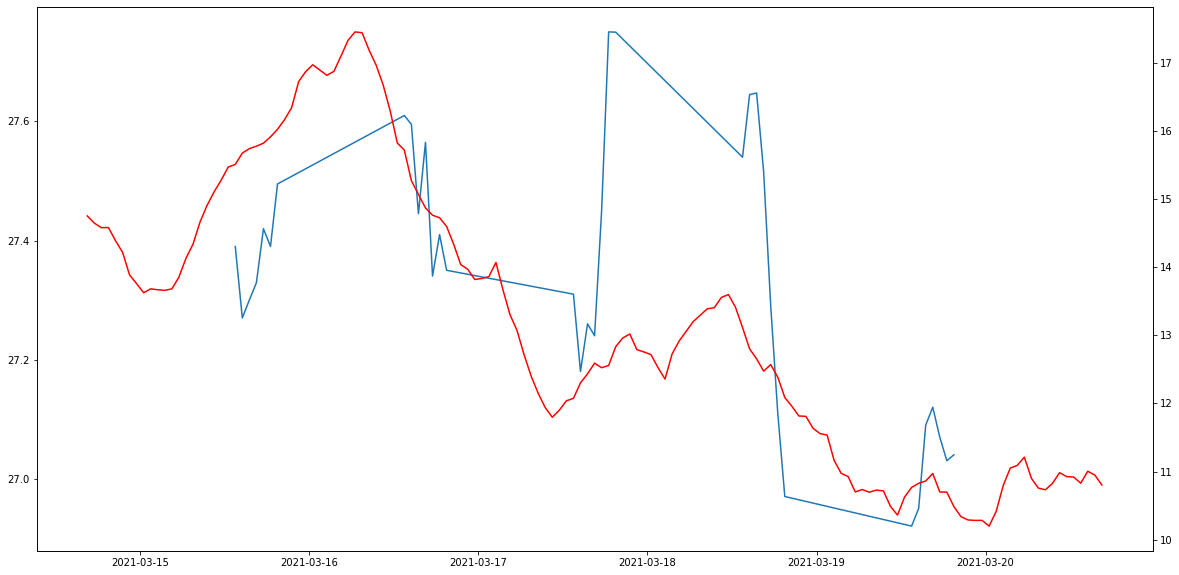

In [32]:
# Smooth the cyurve


df_tweet_sentiment_by_hr['flare_positive_ratio_mov_avg'] = df_tweet_sentiment_by_hr['flare_positive_ratio'].rolling(24).sum()

plt.rcParams['figure.figsize']=(20,10) # set the figure size
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # set up the 2nd axis
#ax1.plot(drive_etf['pct_change']) 
ax1.plot(drive_etf['Close']) 
#x2.plot(df_tweet_sentiment_by_hr['flare_positive_ratio'], color='red')
ax2.plot(df_tweet_sentiment_by_hr['flare_positive_ratio_mov_avg'], color='red')




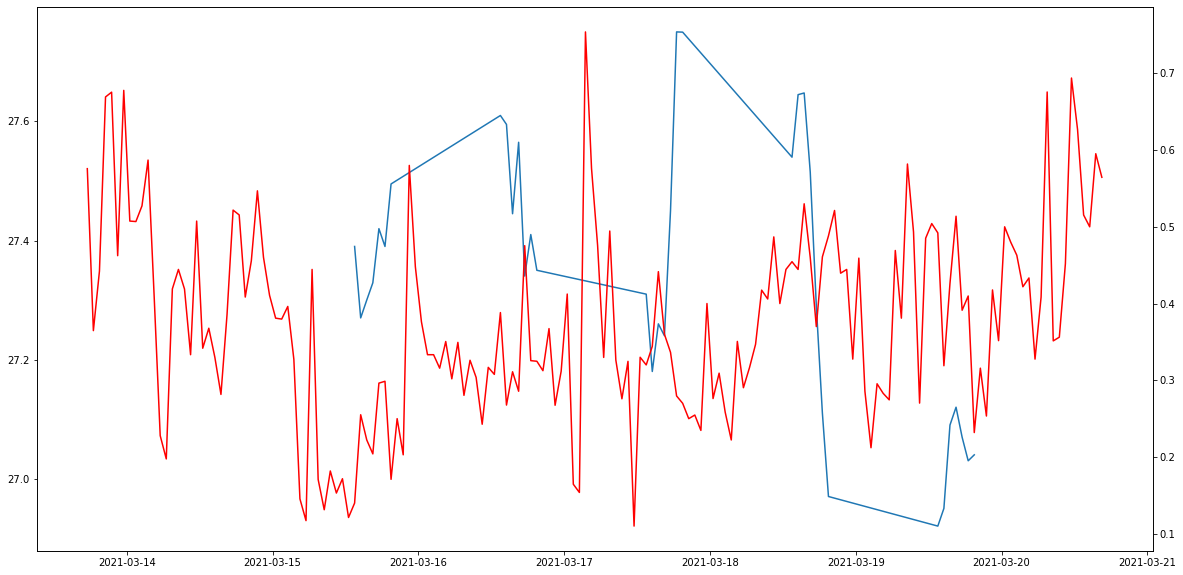

In [33]:
# Vader

df_tweet_sentiment_by_hr['vader_positive_ratio_mov_avg'] = df_tweet_sentiment_by_hr['vader_positive_ratio'].rolling(24).sum()

plt.rcParams['figure.figsize']=(20,10) # set the figure size
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # set up the 2nd axis
ax1.plot(drive_etf['Close']) 
ax2.plot(df_tweet_sentiment_by_hr['vader_positive_ratio'], color='red')

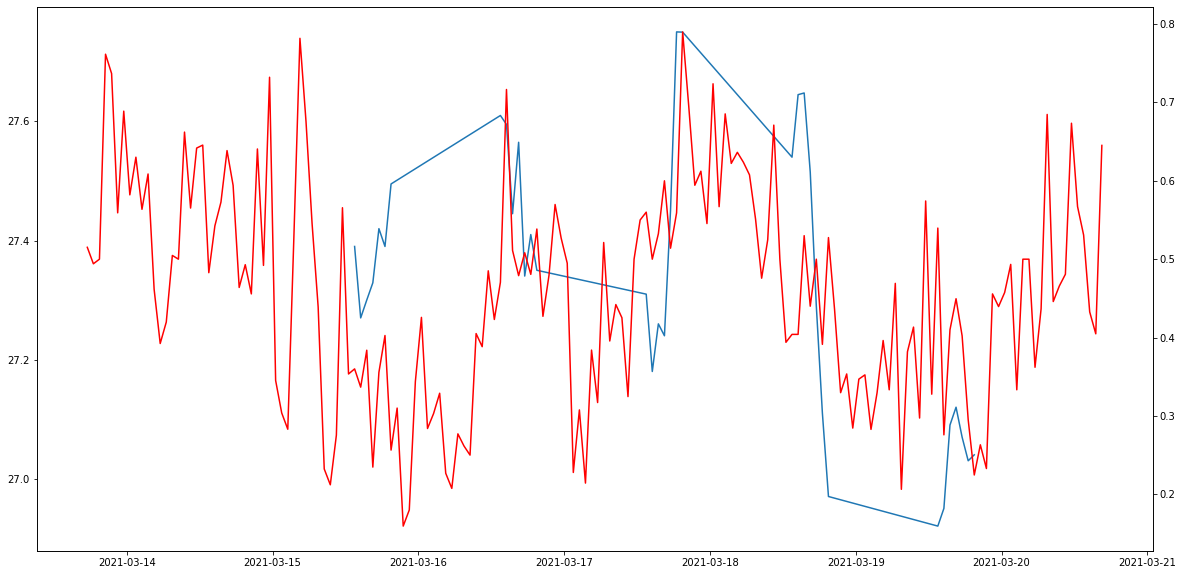

In [34]:
# Text Blob


df_tweet_sentiment_by_hr['txtblob_positive_ratioo_mov_avg'] = df_tweet_sentiment_by_hr['txtblob_positive_ratio'].rolling(24).sum()

plt.rcParams['figure.figsize']=(20,10) # set the figure size
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # set up the 2nd axis
ax1.plot(drive_etf['Close']) 
ax2.plot(df_tweet_sentiment_by_hr['txtblob_positive_ratio'], color='red')

In [35]:
# Merge the tweets and stocks

# No need to strip out non-matching days as join is left join by default
df_merged = drive_etf.join(df_tweet_sentiment_by_hr)

#Keep only columns we need for the analysis
df_merged = df_merged[['pct_change','Close', 'flare_positive_ratio','vader_positive_ratio','txtblob_positive_ratio']]
df_merged.head()

,pct_change,Close,flare_positive_ratio,vader_positive_ratio,txtblob_positive_ratio
DatetimeUTC,,,,,
2021-03-15 13:30:00,0.000000,27.389999,0.670000,0.140000,0.360000
2021-03-15 14:30:00,-0.004381,27.270000,0.826531,0.255102,0.336735
2021-03-15 15:30:00,0.001100,27.299999,0.666667,0.222222,0.383838
2021-03-15 16:30:00,0.001062,27.329000,0.663265,0.204082,0.234694
2021-03-15 17:30:00,0.003326,27.419901,0.696296,0.296296,0.355556


In [51]:
# Feature engineer the previous hour's closing price


df = df_merged.copy()
prev_hour_close_price = df.shift(periods=1).fillna(method='backfill')[['Close']]
prev_hour_close_price = prev_hour_close_price.rename(columns={"Close": "PrevClose"})
prev_hour_close_price

df2 = df.join(prev_hour_close_price)

In [57]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import numpy as np


def run_random_forest(X, y):
    # to make this notebook's output stable across runs
    np.random.seed(123)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    np.random.seed(123)
    model_rf = RandomForestRegressor(n_estimators=500, oob_score=True)
    model_rf.fit(X_train, y_train) 
    pred_train_rf= model_rf.predict(X_train)

    #print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
    print('Training r-squared score : ' + str(r2_score(y_train, pred_train_rf)))

    pred_test_rf = model_rf.predict(X_test)
    #print(np.sqrt(mean_squared_error(y_test,pred_test_rf)))
    print('Testing r-squared score : ' + str(r2_score(y_test, pred_test_rf)))

def run_random_forest_with_scaling(X, y):
    # to make this notebook's output stable across runs
    np.random.seed(123)

    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    np.random.seed(123)
    model_rf = RandomForestRegressor(n_estimators=500, oob_score=True)
    model_rf.fit(X_train, y_train) 
    pred_train_rf= model_rf.predict(X_train)

    #print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
    print('Training r-squared score : ' + str(r2_score(y_train, pred_train_rf)))

    pred_test_rf = model_rf.predict(X_test)
    #print(np.sqrt(mean_squared_error(y_test,pred_test_rf)))
    print('Testing r-squared score : ' + str(r2_score(y_test, pred_test_rf)))

y = df['Close']


print('\nRandom Forest with Flare sentiment\n')
X = df2.copy()[['flare_positive_ratio', 'PrevClose']]
run_random_forest(X, y)

print('\nRandom Forest with Vader sentiment\n')
X = df2.copy()[['vader_positive_ratio', 'PrevClose']]
run_random_forest(X, y)

print('\nRandom Forest with TextBlob sentiment\n')
X = df2.copy()[['txtblob_positive_ratio', 'PrevClose']]
run_random_forest(X, y)

print('\nRandom Forest with all sentiments\n')
X = df2.copy()[['txtblob_positive_ratio', 'vader_positive_ratio', 'flare_positive_ratio', 'PrevClose']]
run_random_forest(X, y)



Random Forest with Flare sentiment

Training r-squared score : 0.9352343315236256
Testing r-squared score : 0.610144481625054

Random Forest with Vader sentiment

Training r-squared score : 0.9491031567134328
Testing r-squared score : 0.6496209555359236

Random Forest with TextBlob sentiment

Training r-squared score : 0.9577227064641741
Testing r-squared score : 0.7271068279264735

Random Forest with all sentiments

Training r-squared score : 0.9424047188840486
Testing r-squared score : 0.7707965410703868
